In [1]:
import cv2
import os
import pandas as pd

import torch
from torch import nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets 

from torchmetrics.classification import BinaryAccuracy
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torchmetrics import ConfusionMatrix

import copy
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet
from utils.trainer import *

In [2]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, basePath, modelName, EPOCHS, LR, batchSize, imgSize):
        self.trainPath = basePath + "train/"
        self.testPath = basePath + "test/"
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.Is = (imgSize, imgSize)
        self.train_validate_percent = 0.95
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.modelName = modelName

config = Configuration(basePath="../datasets/Retinal_OCT/", modelName="efficientnet-b0", EPOCHS=25, LR=0.0001, batchSize=64, imgSize=32)

In [3]:
# Using transforms to augment data by randomizing in multiple ways, rotation, translation, and scaling
train_transform = transforms.Compose([
                                        transforms.Resize(size=config.Is),
                                        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Test and Validation transformations did not have the same modifications
test_transform = transforms.Compose([
                                        transforms.Resize(size=(128,128)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [4]:
#Load generator
from utils.Models import SR_Generator
Generator = SR_Generator( body_arch= [(5,64)]).to(config.device)
test_input = torch.rand(1,3,32,32).to(config.device)
_=Generator(test_input)
Generator.load_state_dict(torch.load("models/generator_model_285.pth"))

Generator.eval()

train = CustomDataset(config.trainPath)

# Splits training dataset into training and validation sets
validNum = int(len(train) * config.train_validate_percent)
train, validate = random_split(train, [validNum, len(train) - validNum])

v = copy.deepcopy(validate)
del validate
validate = v

train.dataset.transform = train_transform
validate.dataset.transform = test_transform
train.dataset.generator = Generator


# Creates the initial ImageFolder dataset from the testing path
test = CustomDataset(config.testPath, transform=test_transform)

# Prints infomation about the datasets
print("\nTraining Dataset\n", len(train))
print("\nValidation Dataset\n", len(validate))
print("\nTesting Dataset\n", len(test))

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



Training Dataset
 18156

Validation Dataset
 956

Testing Dataset
 930


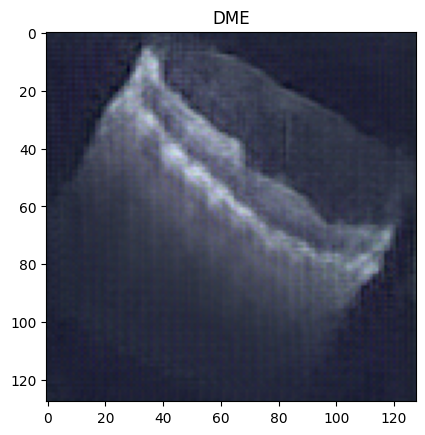

In [5]:
# Precalculated the number each class to ensure a balanced dataset
classTrainCount = {"DME":10847, "DRUSEN":8265} 

# Sets string definitions based on integer values
definitions = {0:"DME", 1:"DRUSEN"}

img, label = train[5]
img = torch.permute(img, (1,2,0))

# View some of the training Data
img = (img-torch.min(img)) / (torch.max(img)-torch.min(img))
plt.imshow(img)
_=plt.title(definitions[label])

In [6]:
# Create all three dataloaders for the training, validating, and testing datasets
trainLoader = DataLoader(train, batch_size=config.bs, shuffle=True, num_workers=0)
validationLoader = DataLoader(validate, batch_size=config.bs, shuffle=True, num_workers=0)
testLoader = DataLoader(test, batch_size=config.bs, shuffle=True, num_workers=0)

In [7]:
testLoader.dataset.generator

In [8]:
# Loads model from the EfficientNet library (pretrained)
model = EfficientNet.from_pretrained(config.modelName)

# Prints the inital fully connected classification layer
print(model._fc, "\n")

# Creates new sequential fully connected classification layers 
model._fc = nn.Sequential(
    nn.Linear(in_features= model._fc.in_features, out_features= 512),
    nn.ReLU(),
    nn.Linear(in_features= 512, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 2),
    nn.Sigmoid(),
)

# Prints new layer
print(model._fc)

Loaded pretrained weights for efficientnet-b0
Linear(in_features=1280, out_features=1000, bias=True) 

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=2, bias=True)
  (5): Sigmoid()
)


In [11]:
# Setup trainer 
Trainer = ModelTrainer(model, nn.BCELoss(), torch.optim.Adam(model.parameters(), lr=config.lr))

In [12]:
Trainer.fit(trainLoader, validationLoader, config.EPOCHS)
Trainer.Test_Model(testLoader)

print("\nTest Accuracy:", Trainer.Metrics["Test Accuracy"])

Trainer.Graph_Metrics()

  3%|██▎                                                                               | 8/284 [00:04<02:52,  1.60it/s]


KeyboardInterrupt: 

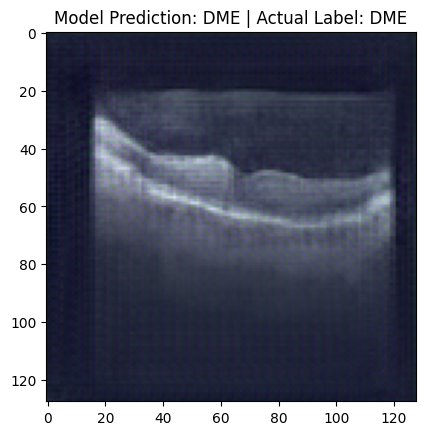

In [17]:
img, label = train[5]

# Make a prediction based on test data
with torch.no_grad():
    pred = Trainer.model(img.reshape(1,3,128,128).to(config.device)) # Replicate a batch with single image
    pred_cls = torch.argmax(pred).item()

img = torch.permute(img, (1,2,0))
img = (img-torch.min(img)) / (torch.max(img)-torch.min(img))

# View some of the testing data and model predictions
plt.imshow(img)
_=plt.title(f"Model Prediction: {definitions[pred_cls]} | Actual Label: {definitions[label]}")

In [26]:
torch.save(Trainer.model.state_dict(), 'models/BC_B.pth')